教授にプレゼン後、データの保存をし、テーブルとして値を持つ必要があることがわかった
大きなデータになるので保存方法を考慮する必要があった。
CSV、Excel、バイナリ、HDF5が候補として挙がった。
HDF5形式は大容量のデータセットを効率的に保存するためのファイル形式であるため、採択。
参考サイトの少なさから一時的にSQLを採択
SQLをテストし、全語句のデータの保存をしてみた
SQLでは、VisualStudioCodeの拡張機能が使いづらく、SQLite3に変更した
SQLite->dataframe->変更->dataframe->変更を保存->SQLiteの完成
上記の方法では変更件数に関わらず、全件で1分30秒かかる。
変更に時間がかかりすぎな点が課題であるため、データの更新方法を検討
SQLからPythonに値を渡さず、直接書き込むことで一件当たり0.1秒以内
拡散ネットワークを作るために、その基盤となるデータセットをSQLに保存
拡散ネットワークに対し、類似度の高いものを想起する事からそれらを加点するため拡散数を３と仮定し拡散
また、拡散ネットワークを作るために、関連文字列に拡散し、ループ一回を拡散と見なしたとき、一回目の入力を除き、n=3の時,3,9,27のように、3^(n-1)のように増えていく。
また実行時間は、0.7,0.8,0.8,4.0,5.9,15.9となっており、線形的に増えている
プログラム自体の計算量はO(N^2)になっている。
拡散した値を仮に0.3として全部をSQLに書き込む処理を追加→成功
SQLから元の値を取得し、Scoreを加算していくことで活性値を表現
活性値が閾値を超えたらループが止まるようにしたいが、5以上の数値は計算上現実的ではない
活性値を超えたら。という考え方自体が並列処理でないため、同時に超えるはずが計算の手順により結果がランダムに決まってしまうことに気づいた。
そのため、理論上下記の仕様に変更する必要がある
活性値を超えたら→活性回数の上限回数を決め、最大の活性値を活性化とする。

In [2]:
import pandas as pd
from gensim.models import Word2Vec
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 学習済みモデルのロード
model_file_path = '../../KITERETU/gw2v160.model'
model = Word2Vec.load(model_file_path)

In [3]:
from gensim.models import Word2Vec
import sqlite3

database_path = 'database2.sqlite'

# データベースに接続し、カーソルを作成する
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# テーブルが存在しない場合のみ作成する
cursor.execute('''CREATE TABLE IF NOT EXISTS words (word TEXT, value REAL)''')

# モデル内のすべての単語と値をデータベースに保存する
for word in model.wv.key_to_index:
    cursor.execute('''INSERT INTO words VALUES (?, ?)''', (word, 0.000000))

# コミットして変更を確定する
conn.commit()

# データベース接続を閉じる
conn.close()


[['其の']]


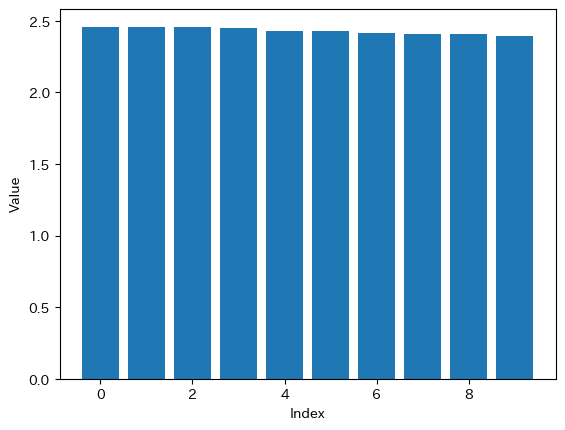

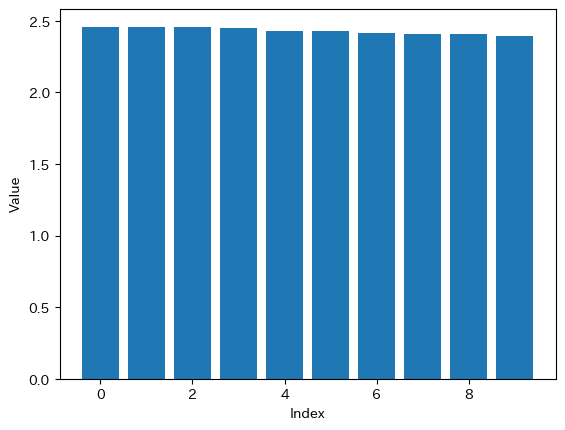

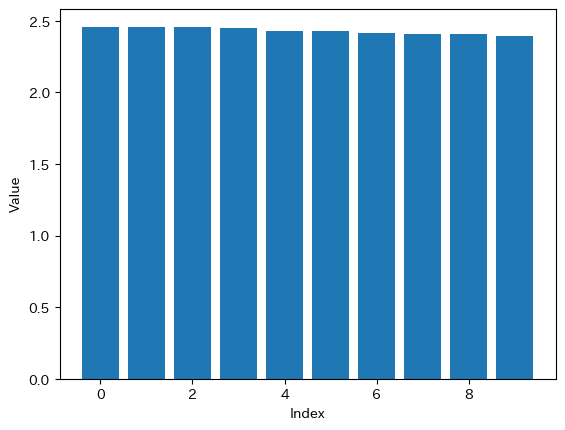

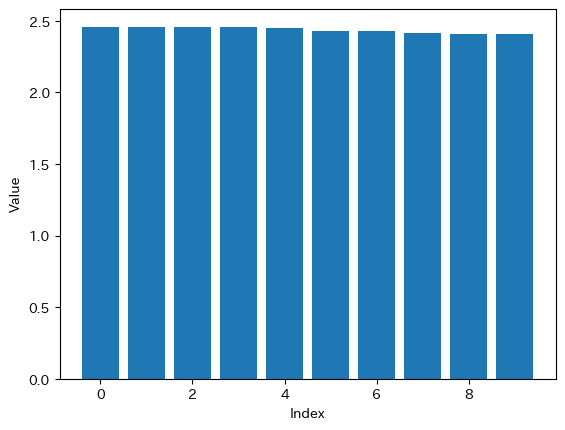

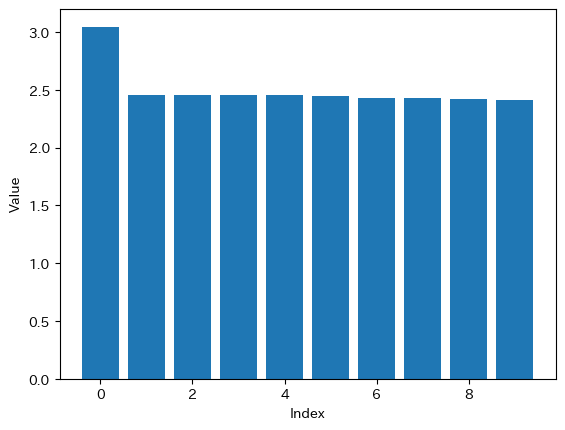

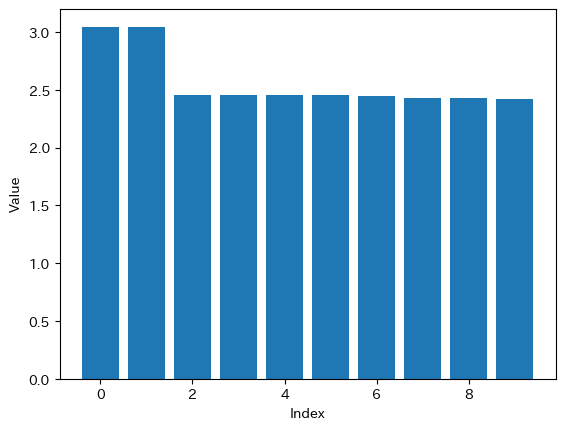

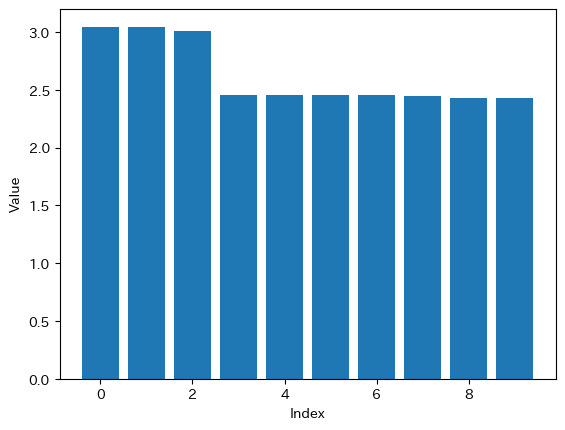

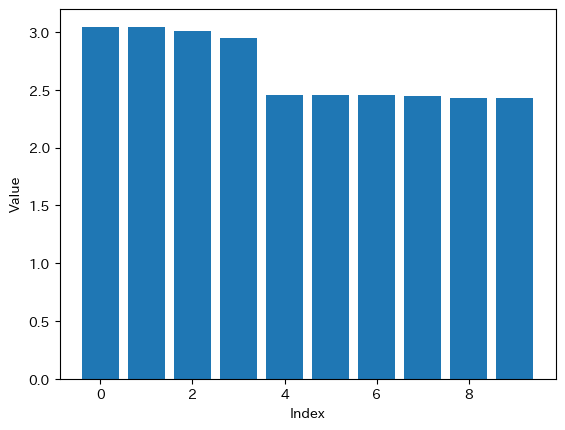

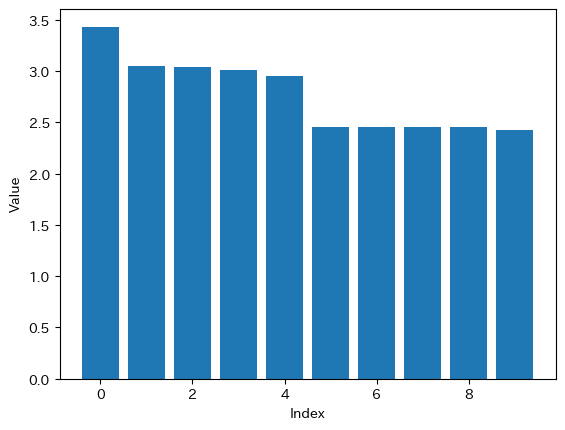

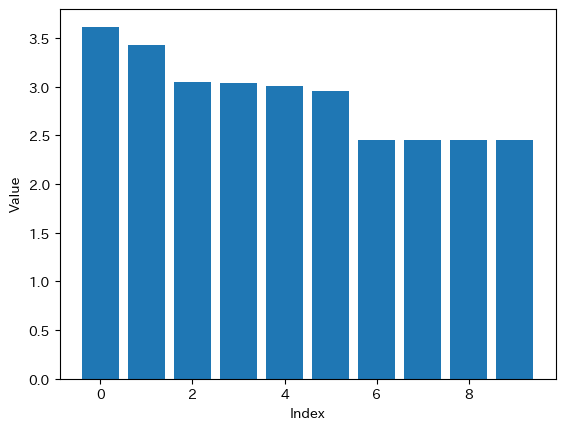

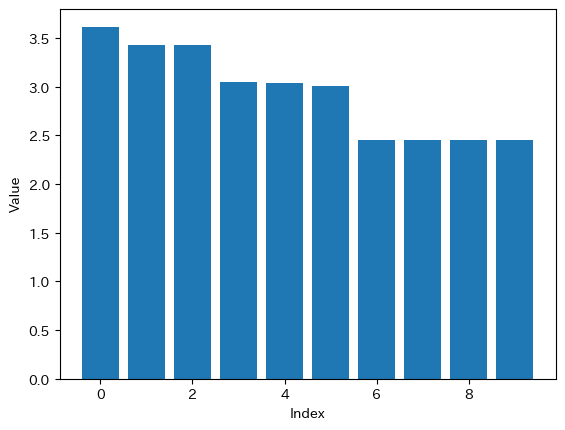

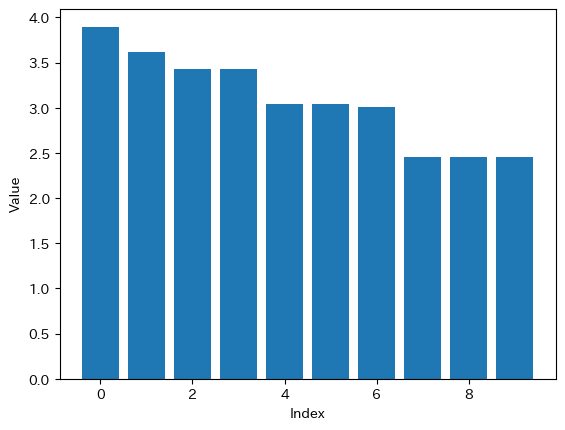

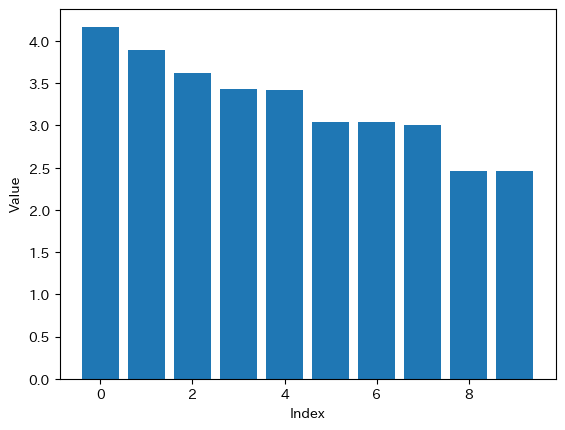

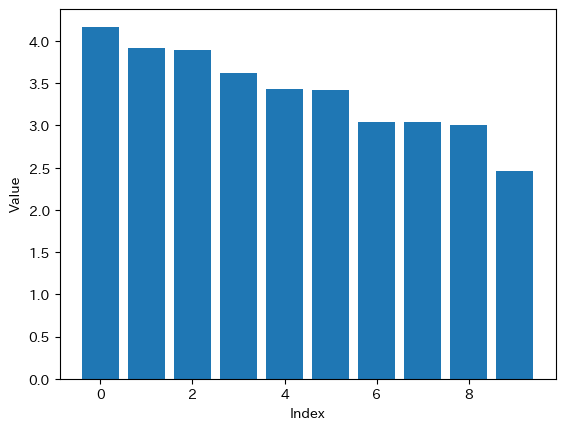

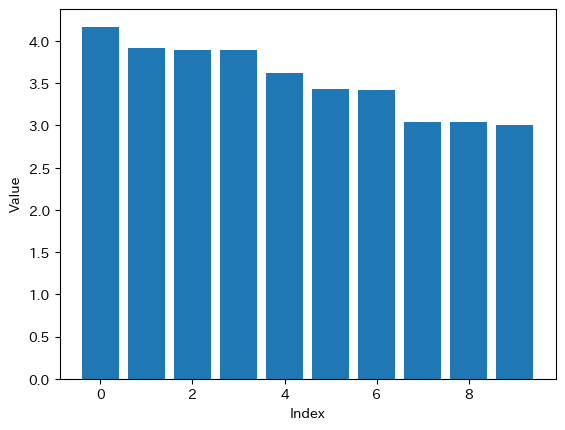

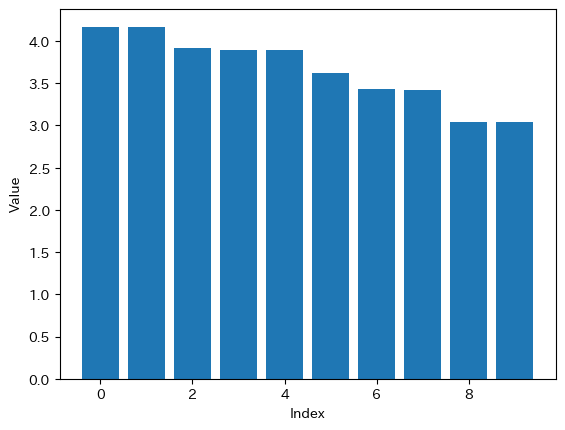

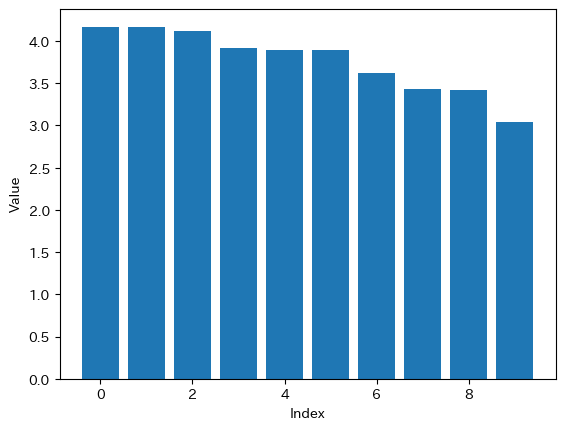

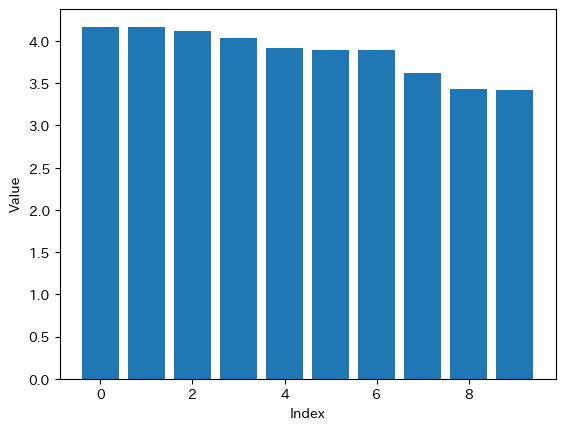

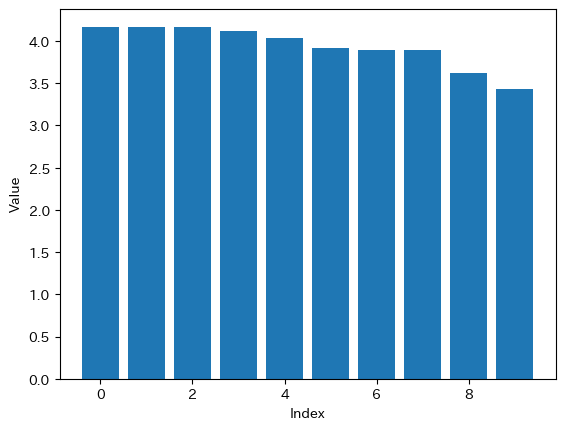

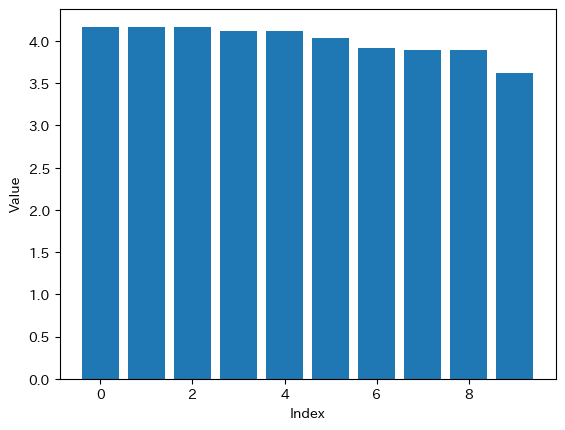

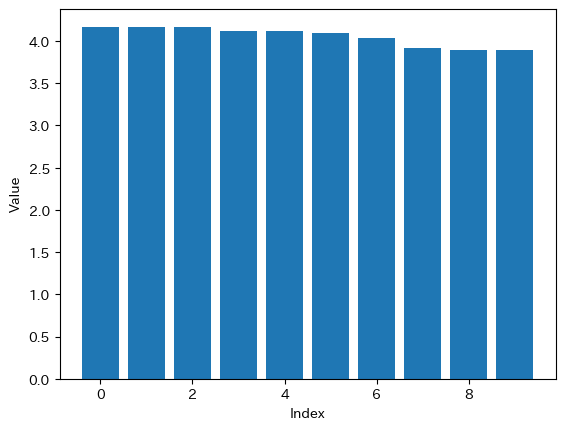

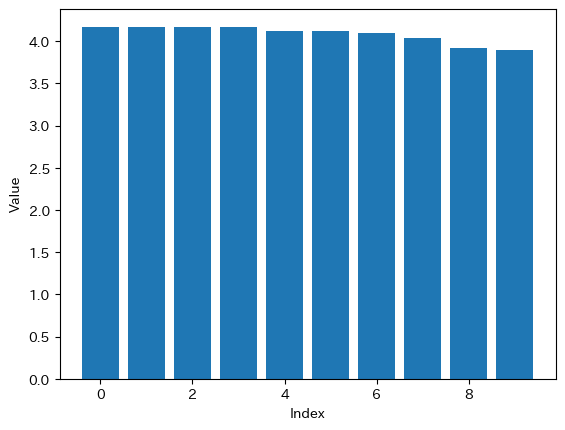

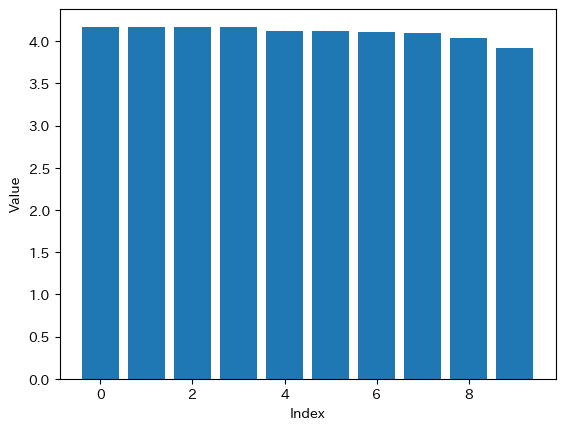

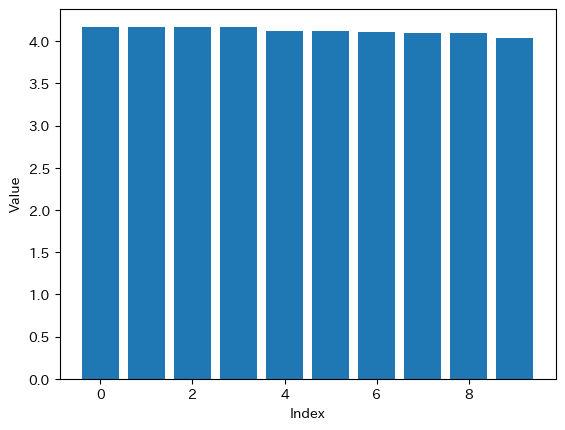

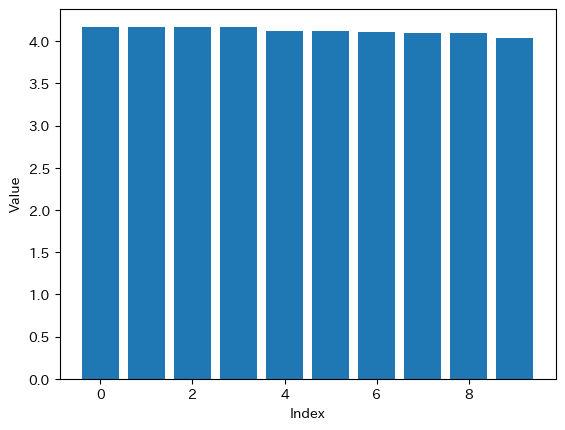

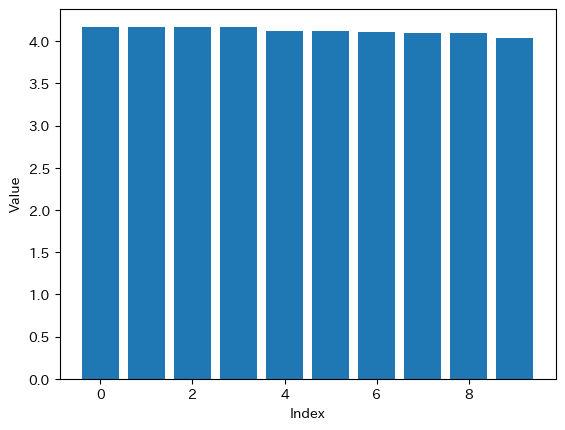

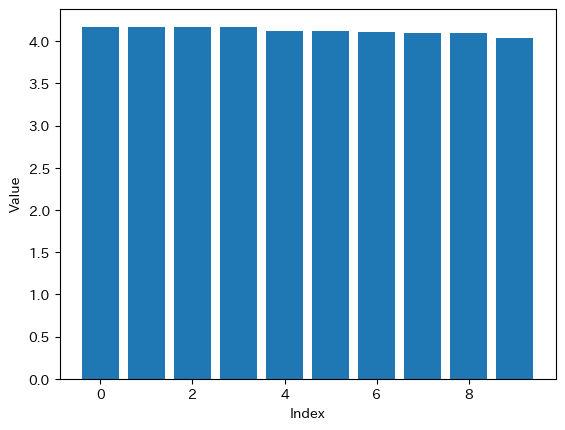

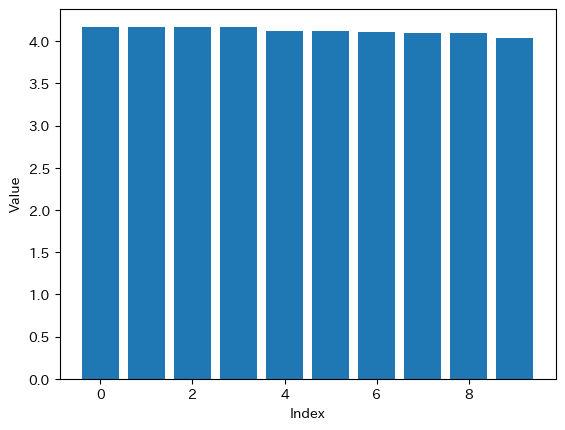

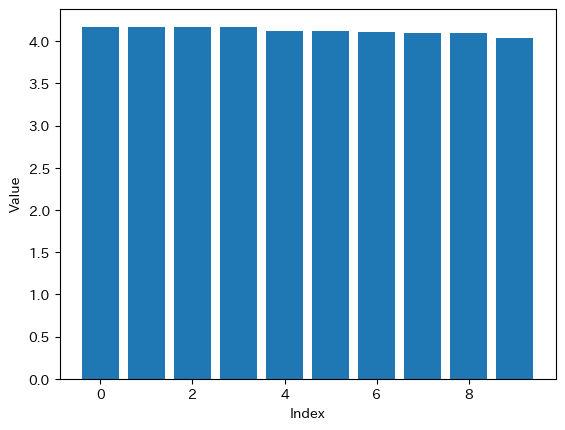

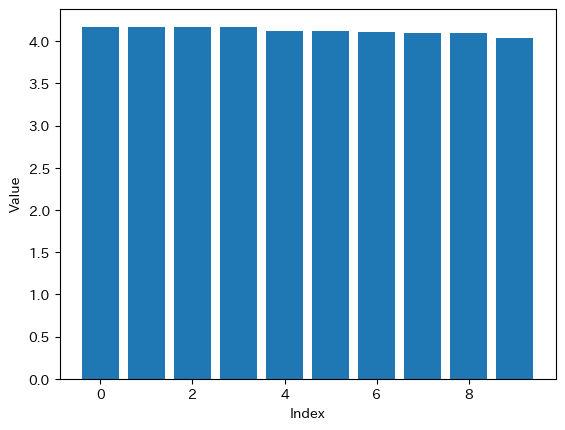

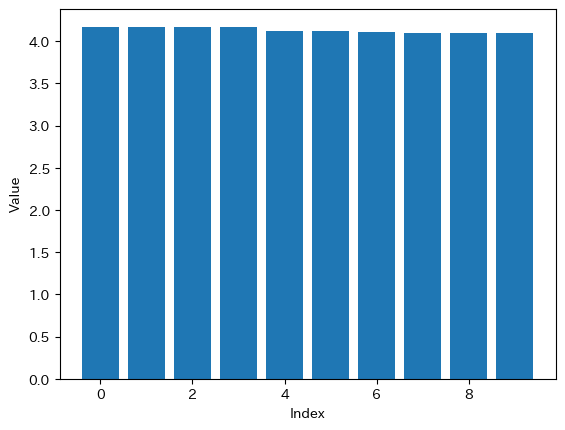

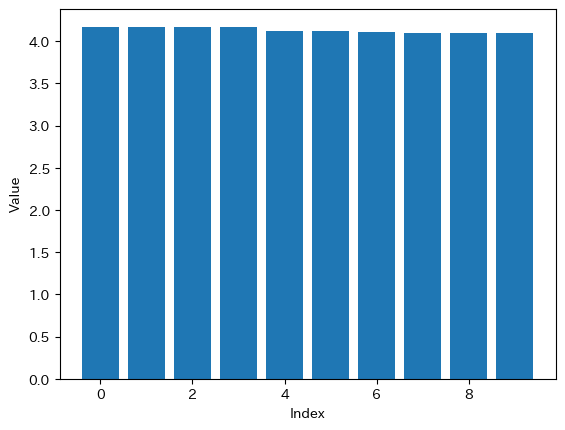

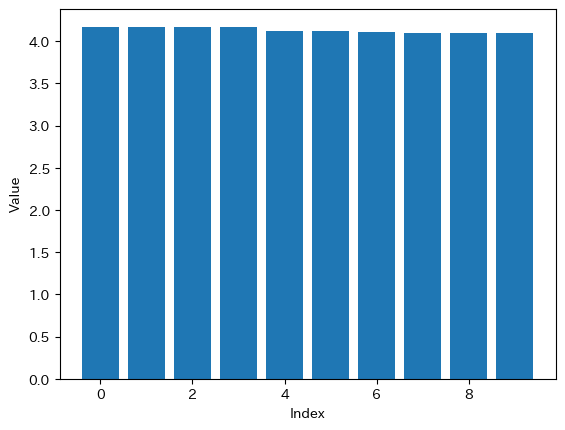

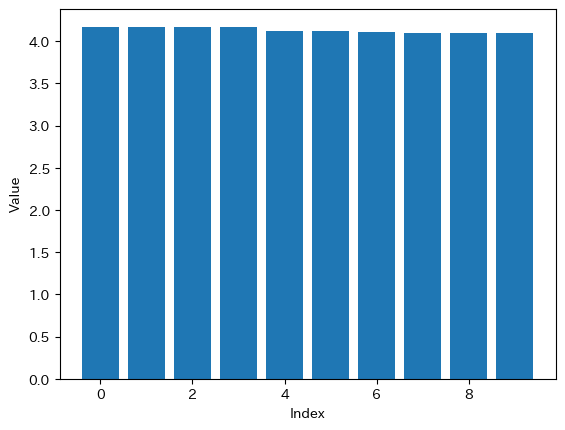

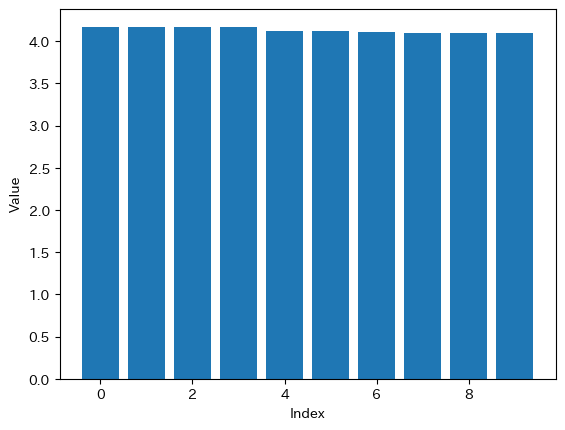

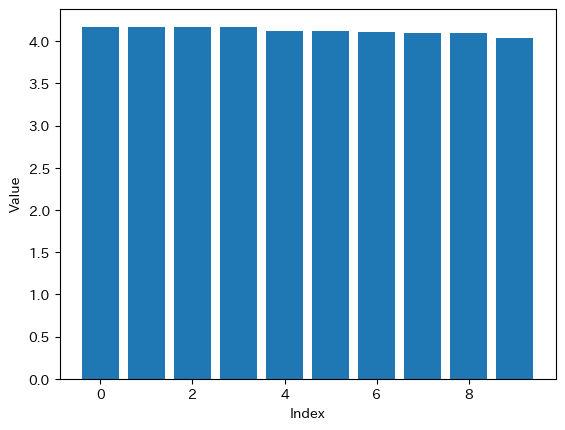

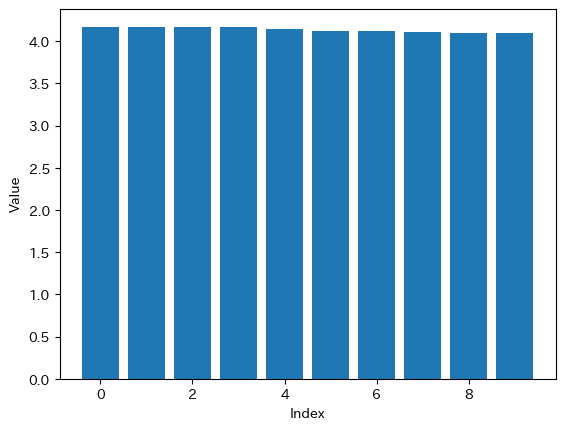

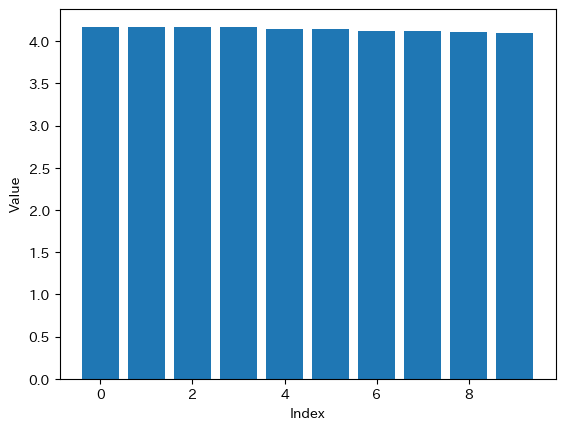

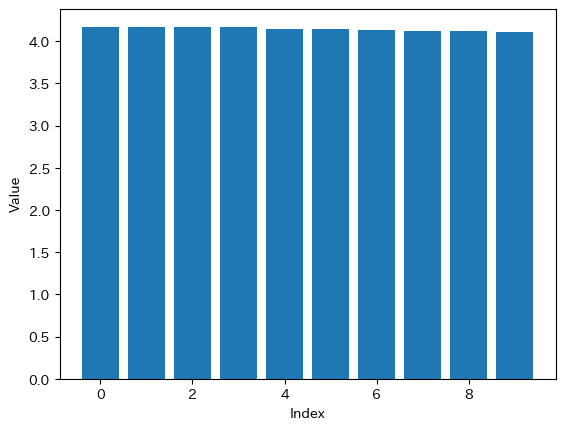

[['其の'], ['此の', '過ぎ行く', '山那'], ['其の', 'どの', '幾つ', '彼の', '其の', '平常', '岐山', '其の', '連峰'], ['此の', '過ぎ行く', '山那', 'どのような', '個々', 'どう', '多く', '様々', '複数', 'こんな', '本当', 'あんな', '此の', '過ぎ行く', '山那', '隔', '万が一', '緊急時', '山那', '衡山', '世杰', '此の', '過ぎ行く', '山那', '妙高山', '山々', '吾妻山']]
1
3
9
27


In [5]:
import sqlite3
import pandas as pd
import sqlite3

# データベースに接続する
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

ans = []
ans.append([input("意味類似度ネットワークを作りたい単語を入力してください===>")])
print(ans)

for i in range(3):
    ans.append([])
    for j in range(len(ans[i])):
        out = model.wv.most_similar(positive=[ans[i][j]], topn=3)
        for prefecture, value in out:
            ans[i+1].append(prefecture)
            # SQLクエリを実行して数値を取得
            cursor.execute("SELECT value FROM words WHERE word = '其の'")
            result = cursor.fetchone()[0]
            new_result = result + value
            val='{:6f}'.format(new_result)
            cursor.execute("UPDATE words SET value = ? WHERE word = ?", (val, prefecture))

            # SQLクエリを実行して結果を取得
            cursor.execute("SELECT value FROM words ORDER BY value DESC LIMIT 10")
            results = cursor.fetchall()
            values = [result[0] for result in results]

            # グラフの作成
            plt.bar(range(len(values)), values)
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.show()            

print(ans)
for i in range(len(ans)):
    print(len(ans[i]))


# コミットして変更を確定する
conn.commit()

# データベース接続を閉じる
conn.close()
